# K-Nearest Neighbor Regression


# Need for scaling:
Below we generate a set of data that are identical (including the added noise, by using the same seed to randomly generate them) but we use different units of measurement for each one. In the data generated the $(x,y)$ on the left panel are measured in units that are different by a factor of $k$ for those in the right panel. For instance, $x$ could be heights and weights of a sample of people. On the left we may use centimeters for height and kilograms for weight. On the right we use the same data but use  400 times smaller for both height and weight. Note that the left panel *looks* more noisy than the right one. 

For this reason most learning algorithms require that we remove units of measurement (make them unitless) by either standardizing or normalizing or applying similar techniques to the data.

Knn is one of those learning algorithms that definitely needs scaling

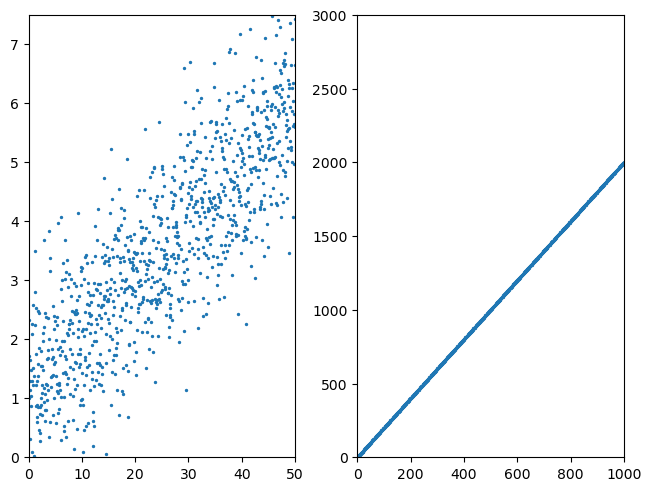

In [4]:
import numpy as np
import matplotlib.pyplot  as plt

n=1000

k=20
x=np.linspace(0,n/k,1000)
np.random.seed(10)
y=1+2*x/k+np.random.normal(0,1,1000)

fig1, (ax11,ax12) = plt.subplots(1,2,constrained_layout=True)

ax11.scatter(x,y,s=2)
ax11.set_ylim(0,3*n/k**2)
ax11.set_xlim(0,n/k)
ax11.set_title("")

k=1
x=np.linspace(0,n/k,1000)
np.random.seed(10)
y=1+2*x/k+np.random.normal(0,1,1000)

ax12.scatter(x,y,s=2)
ax12.set_ylim(0,3*n/k**2)
ax12.set_xlim(0,n/k)
ax12.set_title("")
plt.show()

# Simple Regression with KNN 
This file simulates a data by creating a vector ``t``, and the vector ``y`` by setting $y = f(t) + \epsilon$ where $\epsilon$ is a random error following the normal distribution with mean zero and standard deviation $\sigma$, we use $\sigma=$. We use this data to create a kNN regression model.
 

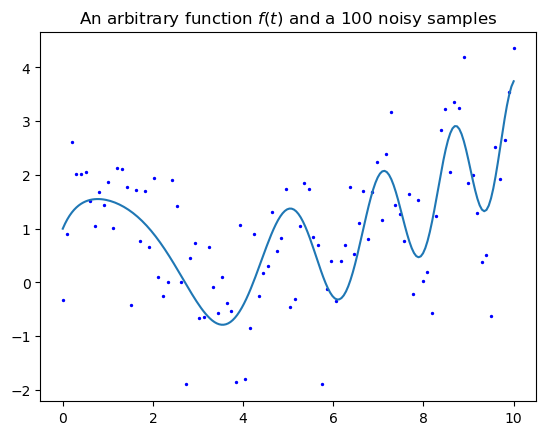

In [106]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

# Define a function:
f = lambda x: 2*x+np.cos(x**2/4)-3*np.log(x+1)**2

#Generate data
n,m = 10,100
t = np.linspace(0,n,m)

# Generate noisy sample data:
y=f(t) + np.random.normal(0,0.9,size=len(t))

#Plot the real function and the scatter data
import matplotlib.pyplot as plt
import seaborn as sn

plt.scatter(t,y,s=2,color='b')
tt=np.linspace(0,n,200)
plt.plot(tt,f(tt))
plt.title(rf"An arbitrary function $f(t)$ and a {m} noisy samples")
plt.show()

## Experiment with some values of $k$ for the $kNN$ method
We now attempt to estimate the dunction $f(t)$ using the $k$NN method. We experiment with several values of $k$. Specifically, We set $k$ to values in the set $\{1,11,21,\dots,91\}$ and observe and compare the learned functions by the $k$NN method with the real function. Note that the most faithful estimate to the data ($k=1$) gives a function that has zero error on the training data, but does not resemble the actual function at all. On the other end of the spectrum, for $k$=91 the estimated function is almost flat, meaning that it is essentially reporting the average of $y$-values from the data. 

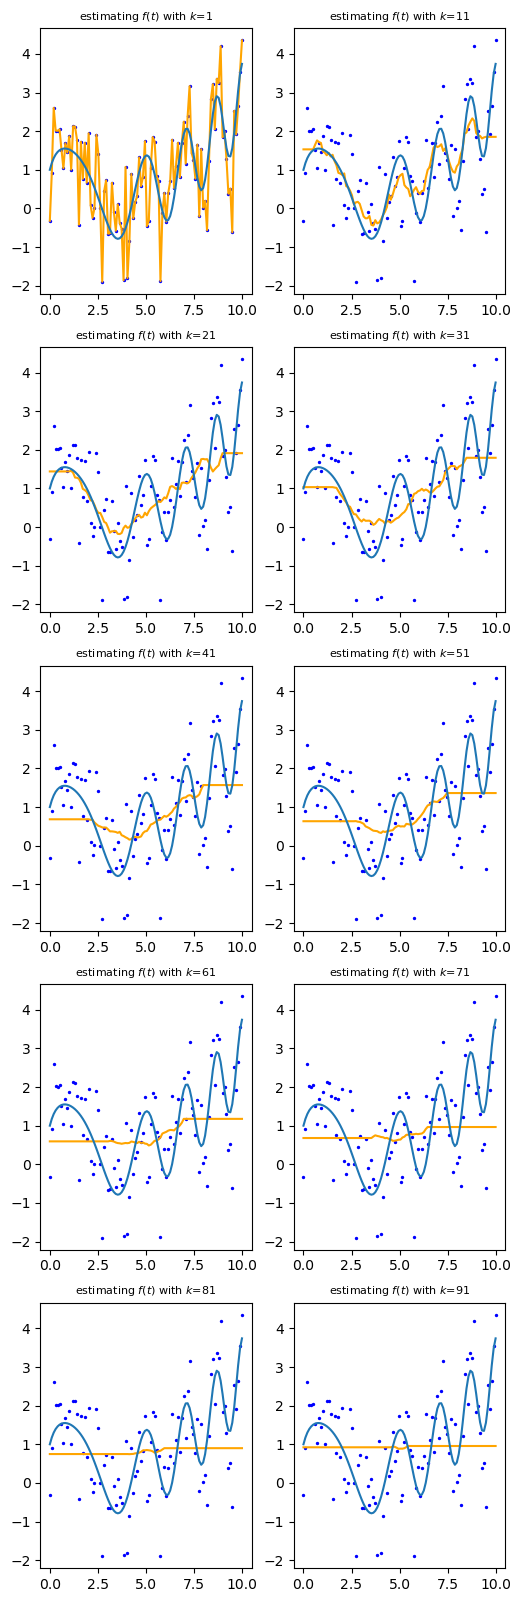

In [109]:
kArray=np.arange(1,100,10) # test k vlaues 1, 11, 21, ..., 91
fig2, ax2 = plt.subplots(kArray.shape[0]//2,2)
fig2.set_size_inches(6,kArray.shape[0]*2)

for i in range(kArray.shape[0]//2):
    for j in [0,1]:
        k=i*2+j
        model=KNeighborsRegressor(n_neighbors=kArray[k])
        model.fit(t.reshape(-1,1),y)  #for X fit fnction needs a two dimensional array, even though t is 1-D. reshape turns it in a 2D array
        testY=model.predict(t.reshape(-1,1))
        ax2[i,j].scatter(t,y,s=2,color='b')
        ax2[i,j].plot(t, testY, color='orange')
        ax2[i,j].plot(t,f(t))
        ax2[i,j].set_title(fr"estimating $f(t)$ with $k$={kArray[k]}",size=8)

#ax2=ax2.reshape((ax2.shape[0]//2,2))
plt.show()

Enter k (0 to exit): 5


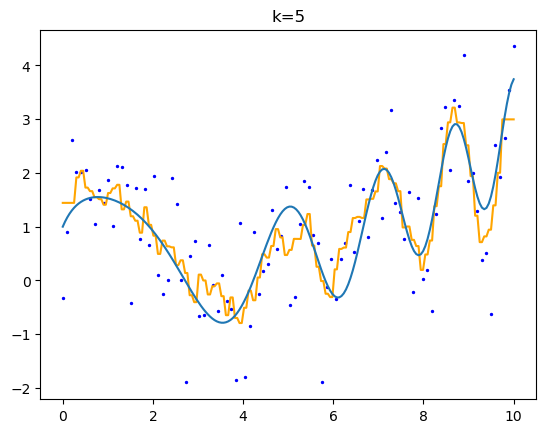

Enter k (0 to exit): 20


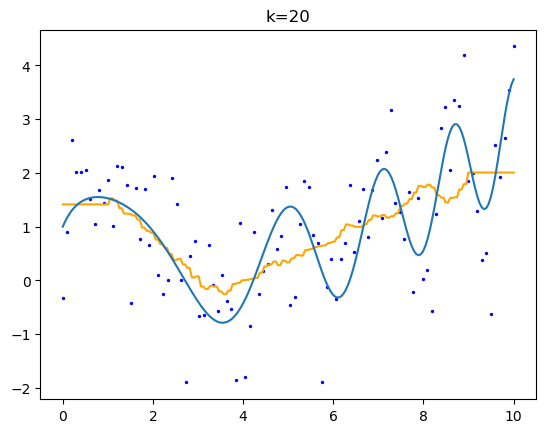

Enter k (0 to exit): 0


In [111]:
#Ask the user for k and generate the knn model

k=int(input('Enter k (0 to exit):'))

while k>0:
    model=KNeighborsRegressor(n_neighbors=k)
    #model=KNeighborsRegressor(n_neighbors=k,weights='distance')
    model.fit(t.reshape(-1,1),y)
    testT=tt
    testY=model.predict(testT.reshape(-1,1))
    plt.scatter(t,y,s=2,color='b')
    plt.plot(testT,testY,color='orange')
    plt.plot(testT, f(testT))
    plt.title(f"k={k}")
    plt.show()
    k=int(input('Enter k (0 to exit):'))

# KNN for Binary Classification

In this example we generate an orange and blue chessboard. The goal is to see if we can build a binary $k$NN model that can "learn" this pattern. In the first stage we generate about 10,000 points and set their color depending on where in the chessboard they fall (details are given below). We then add a small error by moving each point an amount determined by the joint normal distribution of their $x$ and $y$ coordinate. 

The following functions achieve these tasks:

- **plotTrueBoundaries:** this function shows the true color and boundaries
- **genData:** This function generates data with their colors. A random normal error is then added to each point
- **genGridDF:** This function generates a grid of data for the model generated to be tested on
- **testKnn:** this function tests the model built on the test set. It splits the data to train and test set and runs the generated model on the test set
- **plotknnPred** It plots the "heatmap" of predicted probabilities on the generated grid

##  The `plotTrueBoundaries` function
This function takes another function of two variables $f(x,y)$ as input and plots a contour map where points $(x,y)$ where $f(x,y)<0$ are colored with orange and those where $f(x,y)>0$ are colored blue. Depending on the function $f$ a chessboard pattern emerges. See below to see the specific $f(x,y)$ passed to thos function to create an actual chessboard.

In [115]:
def plotTrueBoundaries(f):
    """
    Plot the true bounaries and colors of chessboard pattern
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from scipy import stats
    from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
    
    #The function whose positive and negative values determine the chessboard patter:
    
    # Generate points to plot the contour of level 0 for the real f(x,y):
    x,y=np.linspace(-3,3,100),np.linspace(-3,3,100)
    
    #Set up the two-dimensional grid
    X,Y=np.meshgrid(x,y)
    Z=f(X,Y)
    
    # Plot the true boundaries, and the scatter plot of the data with true colors
    # levels indicated at what values of f(x,y) we wish the contour lines to be drawn. Setting to zero draws the boundaries of chessboard cells
    # The contourf function fills between contour lines  by the specified colors.
    
    plt.contourf(X,Y,Z, levels=0,colors=["orange","cornflowerblue"])
    plt.title("The true boundaries")
    plt.show()

## the genData` function
This function take another function $f(x,y)$ and an integer $N$. It generates $N$ random points $(x_i,y_i)$ and based on whether $f(x_i,y_i)$ is negative or positive, it assigns a color blue or orange to it. 

If we wish to introduce a random error we must also pass the keyword parameter `randErr` ans set it to `True`. This will add a normally distribute random error to the $x$ and $y$ values of each point. The keyword parameter `sigma` determines the standard deviation of the random error. The larger it is the more noisy the data gets. Note that the error is introduced *after* assigning the color. So some originally points where $f(x_i,y_i)<0$ and were colored orange may be thrown into positive territory. Similarly blue points can be thrown into negative territory.

In [118]:
def genData(f,N=1000,randErr=False,sigma=0.2):
    """
    Generate N sample points, determine their colors and return the result in X, y
    X: N x 2 matrix containing the two coordinates of the set of points
    y: N x 1 vector indicting color of each point
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    if N==0: return

    X=np.zeros((N,2))
    X[:,0]=np.random.uniform(-3,3,N)
    X[:,1]=np.random.uniform(-3,3,N)
    y=['cornflowerblue' if f(X[i,0],X[i,1])>0 else 'orange' for i in range(N)]

    # If you want to introduce some error, comment out the line above and
    # uncommnet  the line below

    if randErr:
        y=['cornflowerblue' if f(X[i,0]+np.random.normal(0,sigma),X[i,1]+np.random.normal(0,sigma))>0\
            else 'orange' for i in range(N)]

    #Plot the data with their correct colors and the correct boundary:
    XX,YY=np.meshgrid(np.linspace(-3,3,100),np.linspace(-3,3,100))
    ZZ=f(XX,YY)
    plt.contour(XX,YY,ZZ, levels=0)
    plt.scatter([X[i,0] for i in range(N) if y[i]=='cornflowerblue'],\
                [X[i,1] for i in range(N) if y[i]=="cornflowerblue"],
                color="cornflowerblue",s=2)
    plt.scatter([X[i,0] for i in range(N) if y[i]=='orange'],\
                [X[i,1] for i in range(N) if y[i]=="orange"],
                color="orange",s=2)
    plt.title("colors in the training data")
    plt.show()
    return X,y


## Define the functional form of the chessboard pattern

we now use the functional form of a 5$\times$5 chessboard. The equation of the boundries of this pattern are given by th equation:
$$
f(x,y) = (x-2)\times(x-1)\times x\times(x+1)\times(x+2)\times(y-2)\times(y-1)\times y\times(y+1)\times(y+2)
$$
Note that this function is zero at all points where $x=-2, -1, 0, 1, 2$ or where $y=-2, -1, 0, 1, 2$. At any other point the value is either a positive or a negative number. We color negative values as orange, and positive values as blue. 

To draw the boundaries, that is where $f(x,y)=0$, we use the *contour* map of the function, an ask to only draw curves at value 0. The function `plotTrueBoundaries` achieves this task. The module `matplotlib.pyplot` has several contour plotting functions. See the description and the code for the `plotTrueBoundaries` function. In particular, see how we used the `contourf` function to fill the area between level set. Also we use only a single level set zero to get the chessboard pattern.

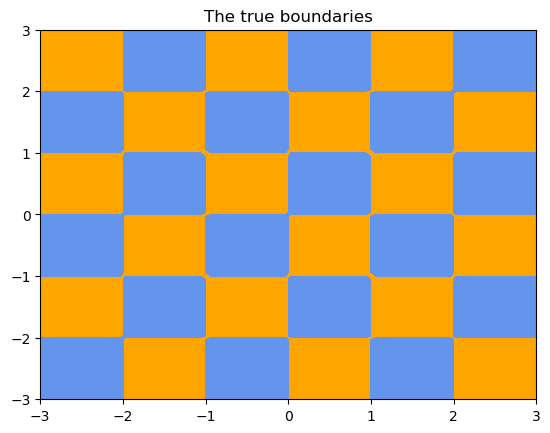

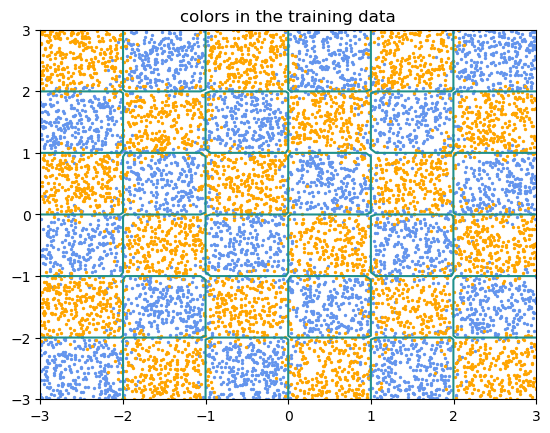

In [131]:
import numpy as np

f=lambda x, y: (x-2)*(x-1)*x*(x+1)*(x+2)*(y-2)*(y-1)*y*(y+1)*(y+2)

# Anpther example to generate a "wavy' chessboard:
#a=2.
#f= lambda x,y: (y+2+0.2*np.cos(a*x))*(y+1+0.2*np.sin(a*x))*(y-0.2*np.cos(a*x))*(y-0.2*np.sin(a*x)-1)*(y-0.2*np.cos(a*x)-2)*\
#               (x+2+0.2*np.cos(a*y))*(x+1+0.2*np.sin(a*y))*(x-0.2*np.cos(a*y))*(x-0.2*np.sin(a*y)-1)*(x-0.2*np.cos(a*y)-2)

plotTrueBoundaries(f)
depth=14

Xchess,yChess=genData(f,N=10000,randErr=True,sigma=0.1)

## Define the data to be tested on:

`genGridDF` generates a data frame containing all the test data. These are data generated on a regular grid, equi-distanced horizontally and vertically.

In [123]:
def genGridDF(xLow, xHigh, xN, yLow, yHigh, yN, xTitle="xNew", yTitle="yNew"):
    """
    This function genrates an xN x yN two-dimensional grid. The x
    range is between xLow and xHigh, and the y range bwtween yLow and yHigh
    It returns the flattenned matrix of the grid.
    """
    import numpy as np
    import pandas as pd

    x1=np.linspace(xLow,xHigh,xN)
    x2=np.linspace(yLow, yHigh,yN)
    
    X=np.zeros((xN*yN,2))
    X[:,0]=np.kron(x1,np.ones(len(x2)))
    X[:,1]=np.kron(np.ones(len(x1)),x2)
   
    return X


## Testing the  $k$NN function

The following function takes a set of two-dimensional data and a value of $k$. It builds a $k$NN model, splits the data into train and test set, train the model on the training set, and finally tests it on the test set. It returns the model, the test set and the predicted probabilities and predicted classes.

In [26]:
def testKnn(k, X, y):
    import numpy as np
    from sklearn.neighbors import KNeighborsClassifier   
    from sklearn.model_selection import train_test_split

    XTrain,Xtest,yTrain,Ytest = train_test_split(X,np.array(y), test_size=0.2)
    
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(XTrain, yTrain) #build the model
    
    yTestPred=classifier.predict(Xtest) #use the model to predict class
    yTestPredP=classifier.predict_proba(Xtest) #and to predict class probability

    return classifier, Xtest, Ytest, yTestPred, yTestPredP

## Code to visulaize prdeiction probabilities

In [125]:
def plotknnPred(model, yColors, modelname=None):
    """
    model: trained model on the sample points from the chesboard data. Must contain pred and 
    predict_proba functions.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sb

    if modelname == None: modelname = "generic model"
    #xx,yy=np.linspace(-3,3,101),np.linspace(-3,3,101)
    xx,yy=np.linspace(-3,3,101),np.linspace(-3,3,101)
    GX,GY=np.meshgrid(xx,yy)
    GZ=model.predict_proba(genGridDF(-3,3,101,-3,3,101))[:,0].reshape(len(xx),len(yy),order='F')
    plt.contour(GX,GY,GZ, levels=[0.5],colors=["teal"])
    
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    #colors=["orange","blue"]
    #cmp = ListedColormap(["orange","goldenrod","gold","yellow", "yellowgreen",\
    #                      "cyan","lightgreen","chartreuse","aqua", "azure","lightblue","cornflowerblue", "blue"])
    cmp=LinearSegmentedColormap.from_list("mycmap", yColors)
    #plt.imshow(GZ[range(GZ.shape[0]-1,0,-1),:], cmap="plasma",\
    #       extent=(-3,3,-3,3))
    plt.imshow(GZ[range(GZ.shape[0]-1,0,-1),:], cmap=cmp,\
            extent=(-3,3,-3,3))   
    plt.colorbar()
    plt.title(f"Probability distribution of prediction for {modelname}")
    plt.show()
    
    plt.contour(GX,GY,GZ, levels=[0.5],colors="teal")
    XG=genGridDF(-3,3,100,-3,3,100)
    rfPred=model.predict(XG)
    realCol=['blue' if f(XG[i,0],XG[i,1])>0 else 'orange' for i in range(XG.shape[0])]
    plt.scatter(XG[:,0], XG[:,1], s=1, color=rfPred)
    plt.title(f"The predicted colors of the grid data with {modelname}")
    plt.show()

## Testing the data:
Below we ineteractively ask for $k$ and then predict on the test data, report the test confusion matrix, and then show the heatmap of the prediction on the grid data:

Enter k (0 to end)
 1


                precision    recall  f1-score   support

cornflowerblue       0.83      0.82      0.82      1004
        orange       0.82      0.83      0.82       996

      accuracy                           0.82      2000
     macro avg       0.82      0.82      0.82      2000
  weighted avg       0.82      0.82      0.82      2000



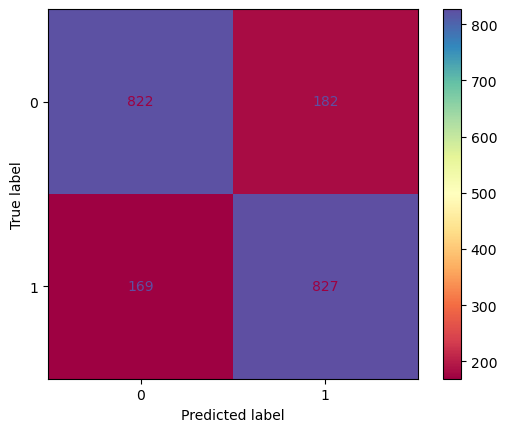

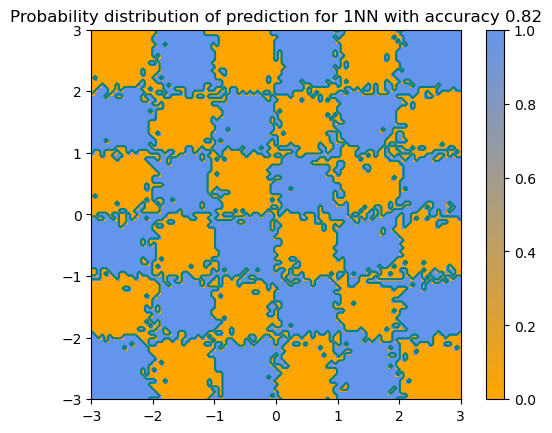

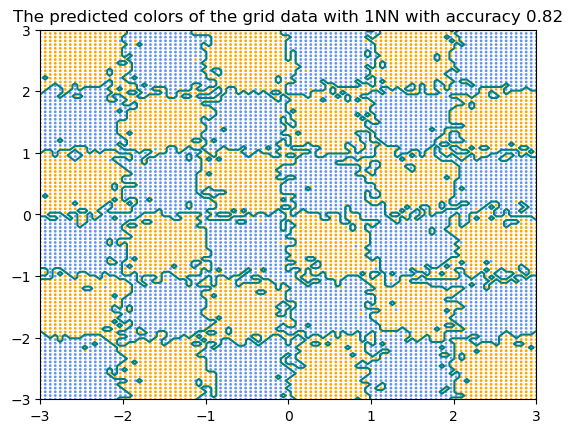

Enter k (0 to end)
 5


                precision    recall  f1-score   support

cornflowerblue       0.88      0.85      0.87      1022
        orange       0.85      0.88      0.87       978

      accuracy                           0.87      2000
     macro avg       0.87      0.87      0.87      2000
  weighted avg       0.87      0.87      0.87      2000



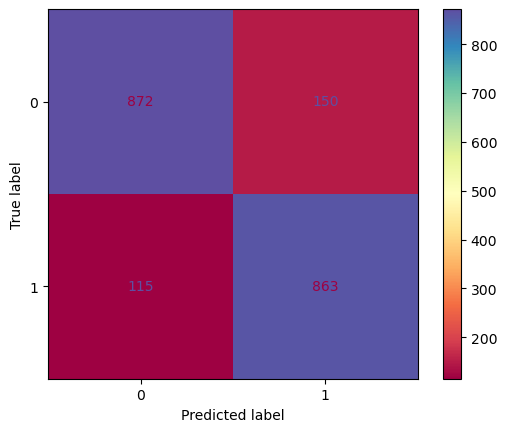

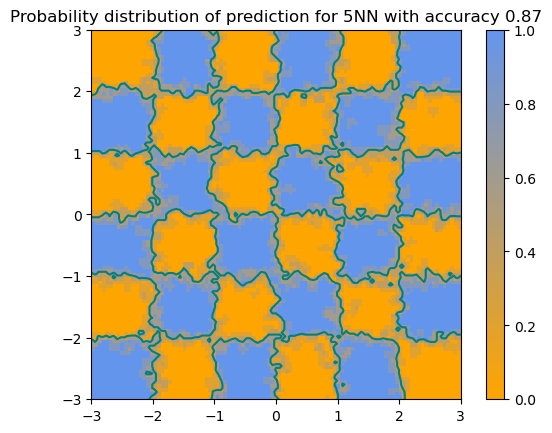

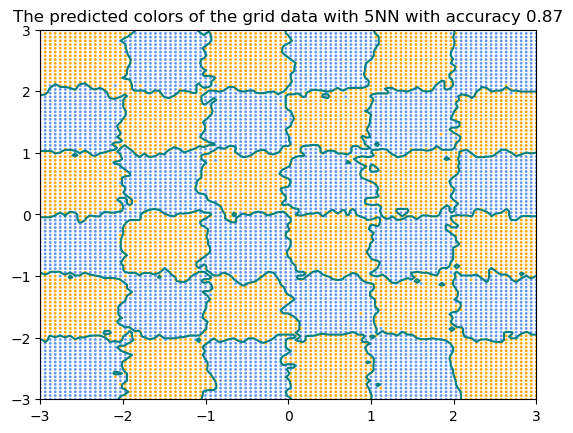

Enter k (0 to end)
 20


                precision    recall  f1-score   support

cornflowerblue       0.86      0.88      0.87      1030
        orange       0.87      0.85      0.86       970

      accuracy                           0.87      2000
     macro avg       0.87      0.87      0.87      2000
  weighted avg       0.87      0.87      0.87      2000



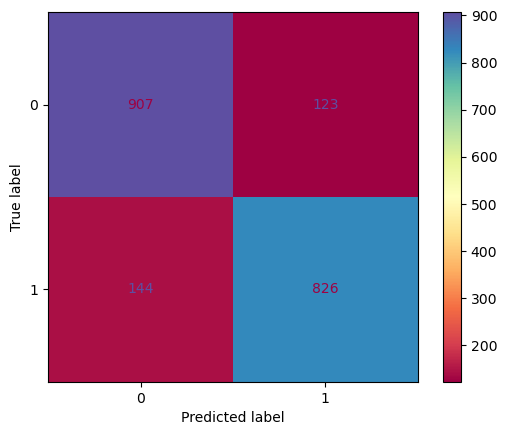

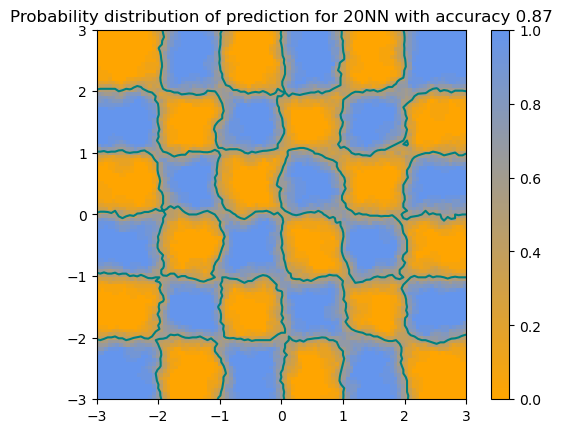

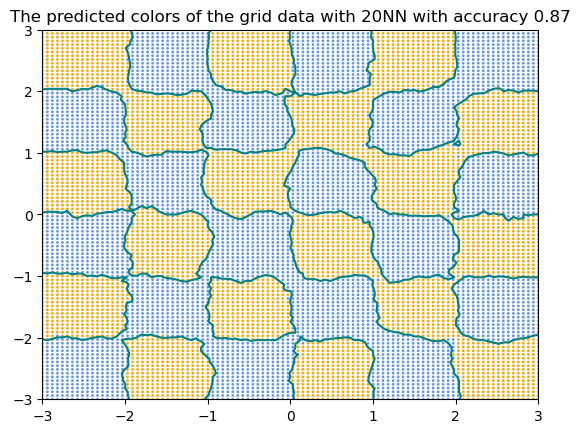

Enter k (0 to end)
 50


                precision    recall  f1-score   support

cornflowerblue       0.86      0.91      0.88       991
        orange       0.90      0.85      0.88      1009

      accuracy                           0.88      2000
     macro avg       0.88      0.88      0.88      2000
  weighted avg       0.88      0.88      0.88      2000



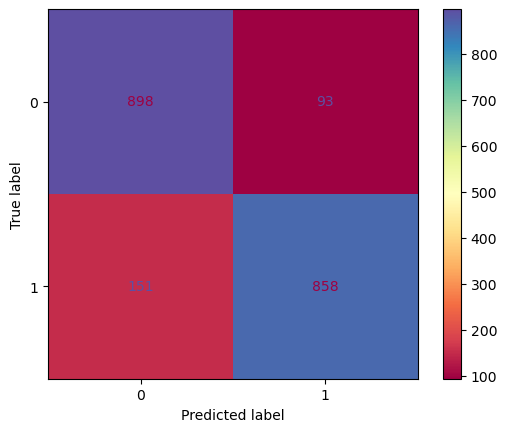

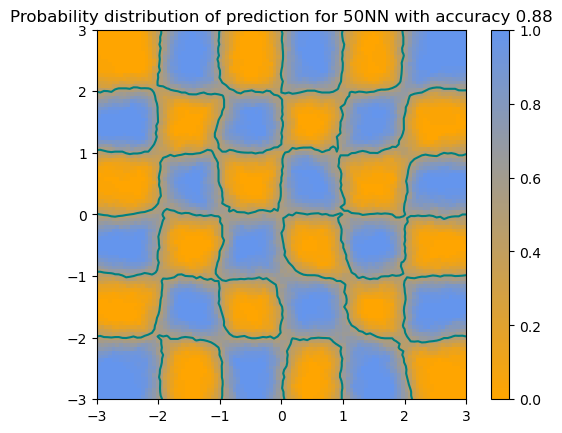

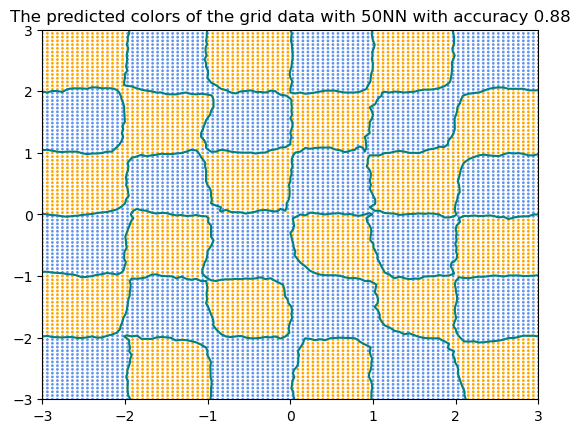

Enter k (0 to end)
 0


In [133]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

k=int(input('Enter k (0 to end)\n'))
while (k>0):
    #newPts = genGridDF(-3,3,100,-3,3,100)
    classifier, XchessTest,YchessTest,ychessTestPred, ychessTestPredP = testKnn(k,Xchess,yChess)

    print(classification_report(YchessTest, ychessTestPred))
    C=confusion_matrix(YchessTest, ychessTestPred)
    ConfusionMatrixDisplay(C).plot(cmap="Spectral")
    plt.show()
    # Since yChess it self is formed of colors, here cornflowerblue and orange, we extract them
    # and pass  them as colors to the `plotknnPred' function:
    plotknnPred(classifier, list(set(yChess)),f"{k}NN with accuracy {np.sum(np.diag(C))/np.sum(C):3.2}")
    k=int(input('Enter k (0 to end)\n'))

# Cross Validation

We test with various values of $k$ and find the one that gives the best accurcy. The methods supplied by ``scikit-learn`` make it possible to run cross validation easily. ``GridSearchCV`` is a powerfull tool for cross validation. 

In [135]:
from sklearn.model_selection import GridSearchCV

kList = list(range(1,801,5))
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kList},verbose=4)
grid.fit(Xchess, yChess)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.822 total time=   0.1s
[CV 2/5] END .....................n_neighbors=1;, score=0.837 total time=   0.1s
[CV 3/5] END .....................n_neighbors=1;, score=0.836 total time=   0.1s
[CV 4/5] END .....................n_neighbors=1;, score=0.833 total time=   0.1s
[CV 5/5] END .....................n_neighbors=1;, score=0.832 total time=   0.1s
[CV 1/5] END .....................n_neighbors=6;, score=0.862 total time=   0.1s
[CV 2/5] END .....................n_neighbors=6;, score=0.856 total time=   0.1s
[CV 3/5] END .....................n_neighbors=6;, score=0.862 total time=   0.1s
[CV 4/5] END .....................n_neighbors=6;, score=0.864 total time=   0.1s
[CV 5/5] END .....................n_neighbors=6;, score=0.860 total time=   0.1s
[CV 1/5] END ....................n_neighbors=11;, score=0.870 total time=   0.1s
[CV 2/5] END ....................n_neighbors=1

/home/farid/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46,
                                         51, 56, 61, 66, 71, 76, 81, 86, 91, 96,
                                         101, 106, 111, 116, 121, 126, 131, 136,
                                         141, 146, ...]},
             verbose=4)

And now we plot the results. Once validation is concluded the results are saved in a list called ``cv_results_``. You can print this list and see the wealth of information contained in it. One information most used is ``cv_results_[mean_test_score]`` which gives the average "score" (here accuracy) for each value of $k$. We plot this score against various values of $k$. WE can use ``semilogx`` which shows the $x$ axisi (that is $k$ here on logarithmic scale. We show both semi-logarithmic and ordianry scle plots. Not that at a certain level $k$ achieves the highest accuracy. This is the data driven optimal $k$ which we can use. 

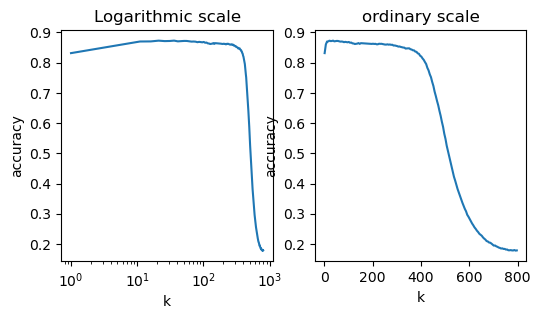

{'n_neighbors': 36}
accuracy = 0.8731


In [137]:
#scores = [val.mean_validation_score for val in grid.grid_scores_]

scores =  grid.cv_results_['mean_test_score']

fig_chess, ax_chess = plt.subplots(1,2)
fig_chess.set_size_inches(6,3)

ax_chess[0].semilogx(kList, scores)
ax_chess[0].set_title("Logarithmic scale")
#fig.title('KNN Classification Model Performance')
ax_chess[0].set_xlabel('k')
ax_chess[0].set_ylabel('accuracy')

ax_chess[1].plot(kList,scores)
ax_chess[1].set_title("ordinary scale")
ax_chess[1].set_xlabel('k')
ax_chess[1].set_ylabel('accuracy')

plt.show()
print(grid.best_params_)
print('accuracy =', grid.best_score_)

#from sklearn.model_selection import cross_val_score
#cross_val_score(GaussianNB(), digits.data, digits.target).mean()

Examine ``cv_results_`` and see what other information it contains. (The cell is hodden. Click on its sidebar to open it.)

# Using kNN method for high dimensional data: MNIST
Now we apply $k$NN to the ``mnist`` hand-written data. This is high dimesnional and multi-class. We use a simple scaling method for this data. Since pixel intensities are between 0 and 255, we simply divide the training feature matrix by 255 to map all numbers to the interval [0,1]. (Also, uncomment the ``Fashion-MNIST``and run the test on this data set as well.)

In [140]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1, parser='auto')
#mnist=fetch_openml('Fashion-MNIST', version=1, parser='auto')

## Scale and Split
Scale the data. Here scaling is easy. Since each image has a gray-scale from 0 to 255, we simply divide all matrices representing images by 255 to get gray scale between zero and one.

Then we split the data into train and test sets with 20% in the test set.

In [144]:
from sklearn.model_selection import train_test_split

X,y=mnist["data"], mnist["target"]

X /= 255.  # scaling to [0,1]
# split into train and test sets:
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(X,y,test_size=0.2,random_state=None)


## Setting up the cross-validation parameter

We set the values of $k$ we wish to test. Since the `MNIST` data is large, setting up $k$NN models make take a long time. Experimenting for a large number of $k$ will, therefore, could take a long time. So, we set `kList` to a small list of values, 1 to 201 with jumps of 10, about 20 instances. We can use a larger list, but it may take a lot longer to complete the computation.  

In [59]:

kList = list(range(1,201, 10))
grid = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': kList}, verbose=5) #set verbose to see progress
grid.fit(X_train_mnist, y_train_mnist) #We train on the training set.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.969 total time=   6.8s
[CV 2/5] END .....................n_neighbors=1;, score=0.971 total time=   7.5s
[CV 3/5] END .....................n_neighbors=1;, score=0.970 total time=   8.5s
[CV 4/5] END .....................n_neighbors=1;, score=0.972 total time=   8.7s
[CV 5/5] END .....................n_neighbors=1;, score=0.972 total time=   9.5s
[CV 1/5] END ....................n_neighbors=11;, score=0.965 total time=   9.3s
[CV 2/5] END ....................n_neighbors=11;, score=0.966 total time=   9.9s
[CV 3/5] END ....................n_neighbors=11;, score=0.964 total time=  10.1s
[CV 4/5] END ....................n_neighbors=11;, score=0.966 total time=   9.9s
[CV 5/5] END ....................n_neighbors=11;, score=0.965 total time=  10.4s
[CV 1/5] END ....................n_neighbors=21;, score=0.958 total time=  10.4s
[CV 2/5] END ....................n_neighbors=21

/home/farid/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91,
                                         101, 111, 121, 131, 141, 151, 161, 171,
                                         181, 191]},
             verbose=5)

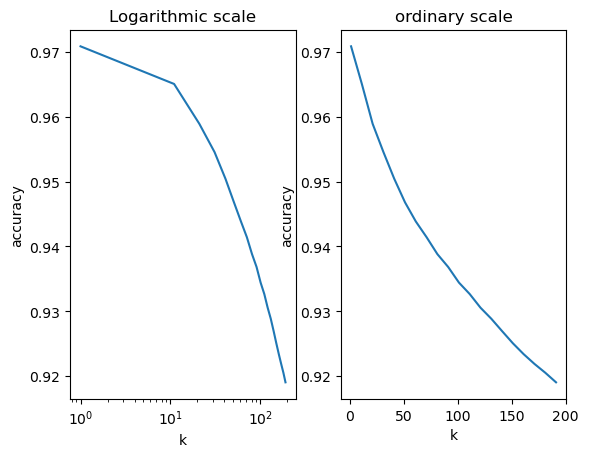

{'n_neighbors': 1}
accuracy = 0.97


In [61]:
#scores = [val.mean_validation_score for val in grid.grid_scores_]
scores =  grid.cv_results_['mean_test_score']

fig_perform,ax_perform = plt.subplots(1,2)

ax_perform[0].semilogx(kList, scores)
ax_perform[0].set_title("Logarithmic scale")
#fig.title('KNN Classification Model Performance')
ax_perform[0].set_xlabel('k')
ax_perform[0].set_ylabel('accuracy')

ax_perform[1].plot(kList,scores)
ax_perform[1].set_title("ordinary scale")
ax_perform[1].set_xlabel('k')
ax_perform[1].set_ylabel('accuracy')

plt.show()
print(grid.best_params_)
print(f"accuracy = {grid.best_score_:4.2}")


#from sklearn.model_selection import cross_val_score
#cross_val_score(GaussianNB(), digits.data, digits.target).mean()

## Running the best model found on the test data
As you may notice the cross validation was trained on the *training* data, and an impressive 97% accuracy was reported on the optimal $k=1$ value. Let us now test the performance of this optimal model on the test data. We do not need to retrain ``KNeighborClassifier`` on the training data again. We simply extract this model which is stored at ``grid.best_estimator_``:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1334
           1       0.97      0.99      0.98      1582
           2       0.99      0.97      0.98      1348
           3       0.97      0.96      0.97      1448
           4       0.98      0.97      0.97      1350
           5       0.96      0.96      0.96      1261
           6       0.97      0.99      0.98      1392
           7       0.97      0.98      0.97      1472
           8       0.98      0.94      0.96      1381
           9       0.96      0.96      0.96      1432

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



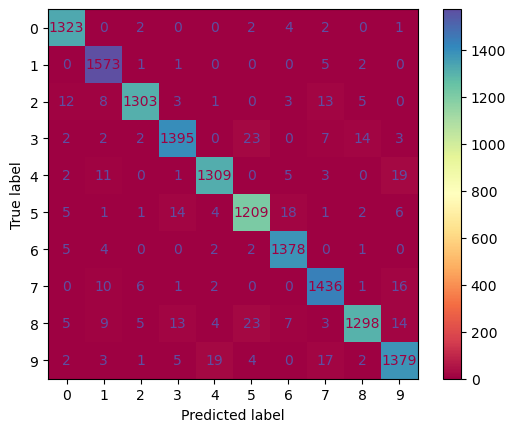

In [67]:
optModel = grid.best_estimator_ # extract the optimal model which is already fit from grid
yPred=optModel.predict(X_test_mnist) # predict the class 
ypredP = optModel.predict_proba(X_test_mnist) # predict the probability distribution of the class
print(classification_report(y_test_mnist,yPred))
C = confusion_matrix(y_test_mnist,yPred)
ConfusionMatrixDisplay(C).plot(cmap="Spectral")

So, when testing the optimal model on the test set, we also get 97% accuracy. In general, and with other data sets we may not achieve the same level of accuracy.

As you see, in the case of hand written digits, the optimal $k$ turns out to be $k=1$. At this level an accuracy of 97% is achieved. The ``mnist`` digits are relatively data. Uncomment, the above to load ``Fashion-mnist`` and comment out the digits. Run the above for the ``Fashion-mnist`` dat and see if there is a difference.

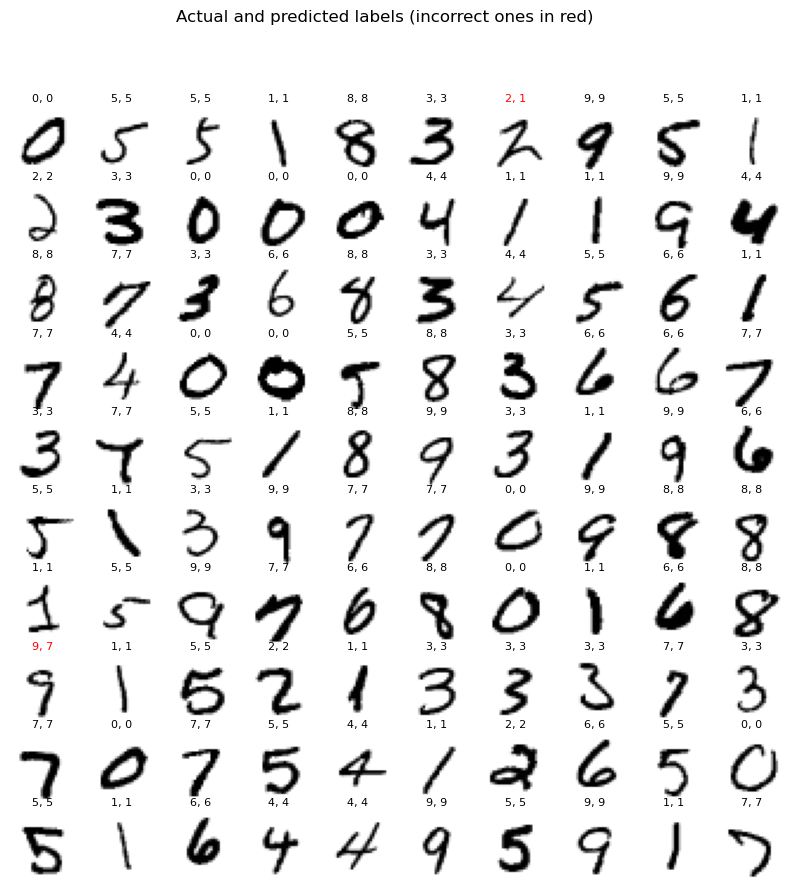

In [78]:
import random
n=10 # n**2 samples will be drawn from the test set and displayed on an n x n grid

fig3=plt.figure(figsize=(n,n))

for i in range(1,n+1):
    for j in range(1,n+1):
        indx=random.randint(0,X_test_mnist.shape[0])

        digitFig=np.array(X_test_mnist.iloc[indx]).reshape((28,28))
        sub3=fig3.add_subplot(n,n,(i-1)*n+j)
        sub3.set_title(f"{y_test_mnist.iloc[indx]}, {yPred[indx]}", size=8, color='black' if y_test_mnist.iloc[indx]==yPred[indx] else 'red')
        sub3.axis('off')
        sub3.imshow(digitFig, cmap='binary')
        #sub.title=f"the {indx}th digit, labeled as {yLabel}"
        #plt.title("First letter T if pic of '3', and F otherwise,\n Second letter same for preduction")
fig3.suptitle("Actual and predicted labels (incorrect ones in red)")
plt.show()

## A sampling of test data and their predictive distribution

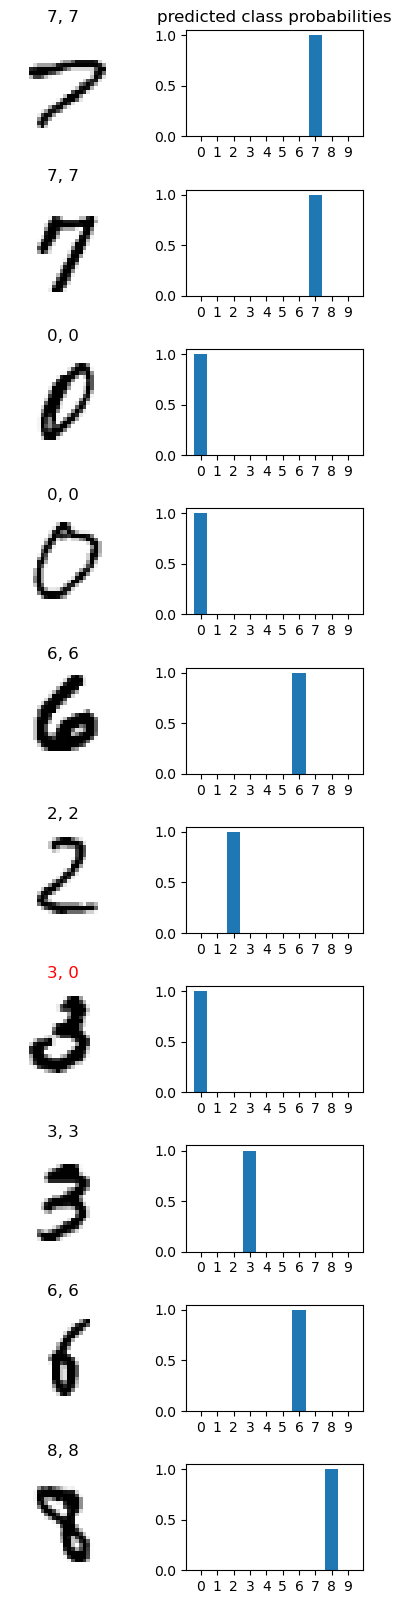

In [99]:
m0=10
ran0=np.random.randint(0,X_test_mnist.shape[0],m0)
fig4, ax4 = plt.subplots(m0,2)
fig4.set_size_inches(5,2*m0)
plt.subplots_adjust(hspace=0.5)
ax4[0,1].set_title("predicted class probabilities")
for i in range(m0):
    ax4[i,0].imshow(np.array(X_test_mnist.iloc[ran0[i]]).reshape((28,28)),cmap='binary')
    ax4[i,0].axis('off')
    ax4[i,0].set_title(f"{y_test_mnist.iloc[ran0[i]]}, {yPred[ran0[i]]}",color='black' if y_test_mnist.iloc[ran0[i]]==yPred[ran0[i]] else 'red')
    ax4[i,1].bar(height=ypredP[ran0[i]],x=range(10))
    ax4[i,1].set_xticks(range(10))